# Ticket inspection AI

## Config

In [147]:
IS_WINDOWS = True
SAVE_AS_BEST = False
OLD_LINJE_TO_NEW = True

# Trials
TWO_TRIALS = 500
FOUR_TRIALS = 1_000

## Imports

In [148]:
import optuna as opt
import pandas as pd
from sdv.evaluation import evaluate
from sdv.tabular import GaussianCopula
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import xgboost as xgb

## Functions

In [149]:
def strCleaner(x: str):
    if isinstance(x, str):
        x = x.lower()
        x = x.replace(" ", "_")

        if "ja" in x:
            return "ja"

        return x
    else:
        return -1


def clockTofloat(x: str) -> float:
    x = x[:-3]
    x = x.replace(":",".")
    x = float(x)
    return x

def extractHour(x):
    return x.hour

def extractMinute(x):
    return x.minute

def findCatCode(l, x: str) -> int:
    for i in range(len(l)):
        if l[i] == x:
            code = l.codes[i]
            return code
        
def datetimeToInt(dt) -> int:
    # second = dt.second
    minute = dt.minute*1
    hour = dt.hour*10
    day = dt.day*10000
    month = dt.month*1000000
    year = dt.year*100000000
    
    ret = minute+hour+day+month+year
    return ret

def extractDay(dt):
    return dt.day
    
def extractMonth(dt):
    return dt.month

def extractYear(dt):
    return dt.year

def convert_linje_to_new(linje_inn):
    match linje_inn:
        case 'l14':
            return 'r14'
        case 'l12':
            return 'r12'
        case 'r11':
            return 're11'
        case 'r10':
            return 're10'
    return linje_inn

# Reading data

In [150]:
if IS_WINDOWS:
    db_main = pd.read_excel('C:/Users/sigzu/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data/Billettkontroll data.xlsx')
    db_aanerud = pd.read_excel('C:/Users/sigzu/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data/Billettkontroll data-aanerud.xlsx')
else:
    db_main = pd.read_excel("/Users/sigurdskyrud/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data/Billettkontroll data.xlsx")
    db_aanerud = pd.read_excel("/Users/sigurdskyrud/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data/Billettkontroll data-aanerud.xlsx")

db_aanerud.head(3)

,Linje,Vogn,Dato,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad
0,R14,Fremst,2023-01-21,16:54:00,Skarnes,Oslo s,Nei,Nei,NaN
1,R14,NaN,2023-01-22,17:04:00,Oslo s,Kongsvinger,Nei,Ja,Ble sjekket med en gang toget reiste
2,R14,4,2023-01-27,16:32:00,Oslo s,Årnes,Nei,Nei,NaN


In [151]:
db = pd.concat([db_main, db_aanerud])
db.tail(2)

,Linje,Vogn,Dato,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad
8,R14,1,2023-03-02,14:04:00,Oslo s,Skarnes,Nei,Nei,NaN
9,R14,5,2023-03-10,12:04:00,Oslo s,Skarnes,Nei,Nei,NaN


In [152]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 0 to 9
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Linje     116 non-null    object        
 1   Vogn      115 non-null    object        
 2   Dato      116 non-null    datetime64[ns]
 3   Klokke    116 non-null    object        
 4   Fra       116 non-null    object        
 5   Til       116 non-null    object        
 6   Fullt?    116 non-null    object        
 7   Sjekket?  116 non-null    object        
 8   Merknad   37 non-null     object        
dtypes: datetime64[ns](1), object(8)
memory usage: 9.1+ KB


# Data cleaning and engineering

## Categorize the features

In [153]:
db.fillna(-1)

,Linje,Vogn,Dato,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad
0,L12,Fremst,2022-09-25,11:30:00,Eidsvoll,Oslo Lufthavn,Nei,Nei,-1
1,R10,Bakerst,2022-09-25,21:59:00,Oslo Lufthavn,Eidsvoll,Ja,Ja,-1
2,L12,Fremst,2022-09-26,09:30:00,Eidsvoll,Nationaltheatret,Ja,Nei,-1
3,L12,Bakerst,2022-09-26,13:48:00,Nationaltheatret,Eidsvoll,Ja,Nei,-1
4,R11,Fremst,2022-09-27,06:00:00,Eidsvoll,Oslo Lufthavn,Nei,Ja,Sjekket med en gang
...,...,...,...,...,...,...,...,...,...
5,R14,4,2023-02-21,10:52:00,Skarnes,Oslo s,Nei,Nei,-1
6,R14,5,2023-02-24,12:04:00,Oslo s,Skarnes,Nei,Ja,Storkontroll. Nettsiden sa liten sannsynlighet
7,R14,0,2023-02-25,18:15:00,Lillestrøm,Skarnes,Nei,Nei,-1
8,R14,1,2023-03-02,14:04:00,Oslo s,Skarnes,Nei,Nei,-1


In [154]:
db["Fullt?"] = db["Fullt?"].apply(lambda x: strCleaner(x))
fulltCat = pd.Categorical(db["Fullt?"])
db["Fullt?"] = pd.Categorical(db["Fullt?"]).codes

db["Sjekket?"] = db["Sjekket?"].apply(lambda x: strCleaner(x))
sjekketCat = pd.Categorical(db["Sjekket?"])
db["Sjekket?"] = pd.Categorical(db["Sjekket?"]).codes

db["Fra"] = db["Fra"].apply(lambda x: strCleaner(x))
fraCat = pd.Categorical(db["Fra"])
db["Fra"] = pd.Categorical(db["Fra"]).codes

db["Til"] = db["Til"].apply(lambda x: strCleaner(x))
tilCat = pd.Categorical(db["Til"])
db["Til"] = pd.Categorical(db["Til"]).codes

In [155]:
db["Linje"] = db["Linje"].apply(lambda x: strCleaner(x))

# Converts old lines to new
if OLD_LINJE_TO_NEW:
    db["Linje"] = db["Linje"].apply(lambda x: convert_linje_to_new(x))

linjeCat = pd.Categorical(db["Linje"])
db["Linje"] = pd.Categorical(db["Linje"]).codes

Vogn needs to be converted to a string

In [156]:
db["Vogn"] = pd.Series(db["Vogn"], dtype="string")
db["Vogn"] = db["Vogn"].apply(lambda x: strCleaner(x))

vognCat = pd.Categorical(db["Vogn"])
db["Vogn"] = pd.Categorical(db["Vogn"]).codes

Merknad needs to convert all empty values to -1

In [157]:
db["Merknad"].fillna(-1)

merknadCat = pd.Categorical(db["Merknad"])
db["Merknad"] = pd.Categorical(db["Merknad"]).codes

### Check that categories are correct

In [158]:
print(linjeCat.categories)
print(fraCat.categories)
print(tilCat.categories)
print(fulltCat.categories)
print(sjekketCat.categories)

Index(['l1', 'l2', 'r12', 'r13', 'r14', 're10', 're11'], dtype='object')
Index(['eidsvoll', 'lillestrøm', 'lillestrøm_', 'lørenskog',
       'nationaltheatret', 'oslo_lufthavn', 'oslo_s', 'skarnes', 'skarnes_'],
      dtype='object')
Index(['eidsvoll', 'hamar', 'jessheim', 'kongsvinger', 'lillestrøm',
       'nationaltheatret', 'oslo_lufthavn', 'oslo_s', 'skarnes', 'skarnes_',
       'årnes'],
      dtype='object')
Index(['ja', 'nei', 'noe'], dtype='object')
Index(['ja', 'nei'], dtype='object')


In [ ]:
from collections import deque

In [ ]:
r12_line = deque(["eidsvoll", "eidsvoll_verk", "oslo_lufthavn", "lillestrøm", "oslo_s", "nationaltheateret"])

def recursive_line_creator(db: pd.DataFrame, line_map: deque, first_stop, last_stop):
    

Extract date sub-categories

In [159]:
# db['Dato'] = (db['Dato'] - db['Dato'].min())  / np.timedelta64(1,'D')
# db["Dato"] = db["Dato"].apply(lambda x: datetimeToInt(x))
# db["Dato"].head(3)

In [160]:
db["Dag"] = db["Dato"].apply(lambda x: extractDay(x))
db["Måned"] = db["Dato"].apply(lambda x: extractMonth(x))
# db["År"] = db["Dato"].apply(lambda x: extractYear(x)) # Not relevant for the timescale I have

db = db.drop("Dato", axis=1)
db.head(3)

,Linje,Vogn,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned
0,2,10,11:30:00,0,6,1,1,-1,25,9
1,5,9,21:59:00,5,0,0,0,-1,25,9
2,2,10,09:30:00,0,5,0,1,-1,26,9


Exctract time sub-categories

In [161]:
# db["Klokke"] = pd.Series(db["Klokke"], dtype="str")
# db["Klokke"] = db["Klokke"].apply(lambda x: clockTofloat(x))

In [162]:
db["Time"] = db["Klokke"].apply(lambda x: extractHour(x))
db["Minutt"] = db["Klokke"].apply(lambda x: extractMinute(x))

db = db.drop("Klokke", axis=1)
db.head(3)

,Linje,Vogn,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned,Time,Minutt
0,2,10,0,6,1,1,-1,25,9,11,30
1,5,9,5,0,0,0,-1,25,9,21,59
2,2,10,0,5,0,1,-1,26,9,9,30


In [163]:
# Vogn is just noise
db = db.drop("Vogn", axis=1)

In [164]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 0 to 9
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Linje     116 non-null    int8 
 1   Fra       116 non-null    int8 
 2   Til       116 non-null    int8 
 3   Fullt?    116 non-null    int8 
 4   Sjekket?  116 non-null    int8 
 5   Merknad   116 non-null    int8 
 6   Dag       116 non-null    int64
 7   Måned     116 non-null    int64
 8   Time      116 non-null    int64
 9   Minutt    116 non-null    int64
dtypes: int64(4), int8(6)
memory usage: 5.2 KB


<Axes: >

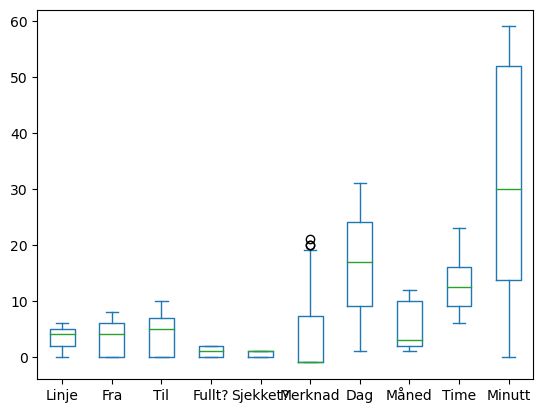

In [165]:
db.plot.box()

# Synthetic data

### Create simulated rides

### SDV

In [166]:
sdv = GaussianCopula()
sdv.fit(db)
sample = sdv.sample(500)
sample.head(3)

,Linje,Fra,Til,Fullt?,Sjekket?,Merknad,Dag,Måned,Time,Minutt
0,4,6,1,2,1,6,29,2,14,42
1,5,6,3,1,1,1,18,10,21,16
2,5,1,3,1,0,15,2,2,10,35


In [167]:
# Dont work
#evaluate(sample, db, metrics=['CSTest'], aggregate=False)

In [168]:
db = pd.concat([db, sample])

# Creating testing data

In [169]:
# Create the data to create predict from
X = db.drop(["Sjekket?"], axis=1)

# Create the data to predict to
y = db["Sjekket?"]

# Merknad has gives no impact on result
X = X.drop(["Merknad"], axis=1)

### Testing without clock
# X = X.drop(["Klokke"], axis=1)

X.head(3)

,Linje,Fra,Til,Fullt?,Dag,Måned,Time,Minutt
0,2,0,6,1,25,9,11,30
1,5,5,0,0,25,9,21,59
2,2,0,5,0,26,9,9,30


# Train_test_split

In [170]:
# Split the data into train and test sets with test_size=0.2 and random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating model1 - XGBoostClassifier

In [171]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [172]:
preds = model.predict(X_test)

## Model 1 testing

### Model 1's confusion matrix

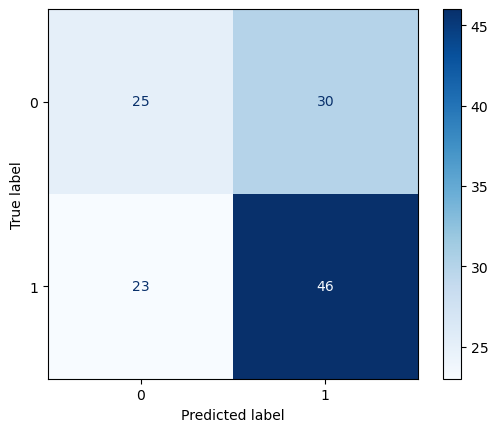

In [173]:
cm = confusion_matrix(y_true=y_test, y_pred=preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot(cmap='Blues')

In [174]:
accuracy = accuracy_score(y_true=y_test, y_pred=preds)
print(f"Accuracy: {accuracy * 100.0 :.2f}")

Accuracy: 57.26


### Model 1's feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

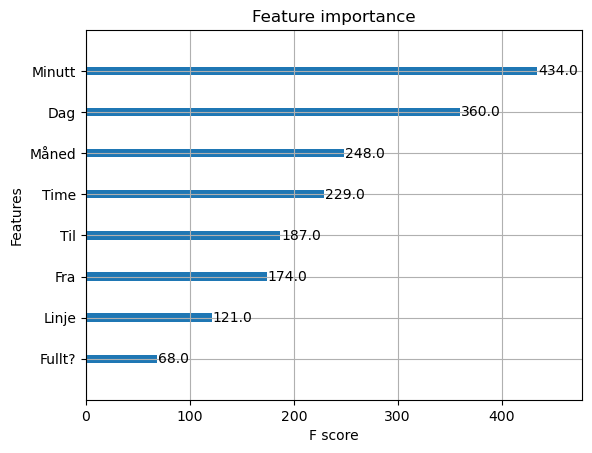

In [175]:
xgb.plot_importance(model)

# Creating model 2 - Model 1 with optuna

In [176]:
def objective(trial):
    """The objective is to find the best parameters for the most accuracy in the model"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1e+3),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss'
    }

    # Fit the model
    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = opt.create_study(direction="maximize")
study.optimize(objective, n_trials=TWO_TRIALS)

[I 2023-03-11 18:42:54,914] A new study created in memory with name: no-name-02c5b9fe-f263-4fae-8b54-3dde6272c721
[I 2023-03-11 18:42:55,036] Trial 0 finished with value: 0.5564516129032258 and parameters: {'max_depth': 9, 'learning_rate': 0.3624746134540042, 'n_estimators': 371, 'min_child_weight': 6, 'gamma': 876.6435050574489, 'subsample': 0.5617401801481878, 'colsample_bytree': 0.7450978953992501, 'reg_alpha': 0.6750868948431068, 'reg_lambda': 0.6920701898991912}. Best is trial 0 with value: 0.5564516129032258.
[I 2023-03-11 18:42:55,075] Trial 1 finished with value: 0.5564516129032258 and parameters: {'max_depth': 4, 'learning_rate': 0.48385229588516243, 'n_estimators': 140, 'min_child_weight': 5, 'gamma': 112.60003926031645, 'subsample': 0.7310237168463675, 'colsample_bytree': 0.2314825965259863, 'reg_alpha': 0.9565751223718983, 'reg_lambda': 0.5146846935525976}. Best is trial 0 with value: 0.5564516129032258.
[I 2023-03-11 18:42:55,199] Trial 2 finished with value: 0.44354838709

In [177]:
bparams = study.best_params
model2 = xgb.XGBClassifier(**bparams)
model2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.41541952690207573, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5105656093016151, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1386030142792524, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=479, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [178]:
preds2 = model2.predict(X_test)

## Model 2 testing

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

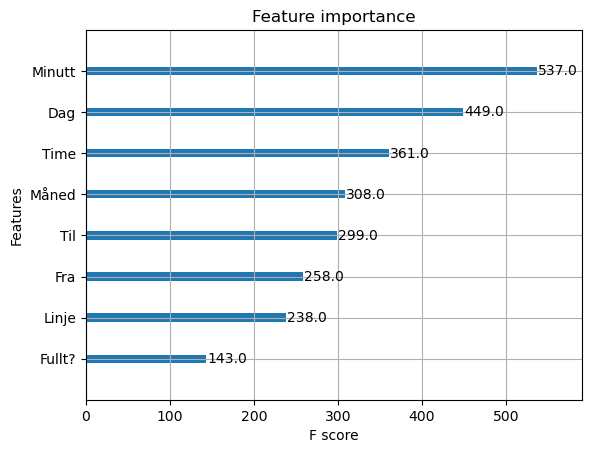

In [179]:
xgb.plot_importance(model2)

### Model 2 Confusion Matrix

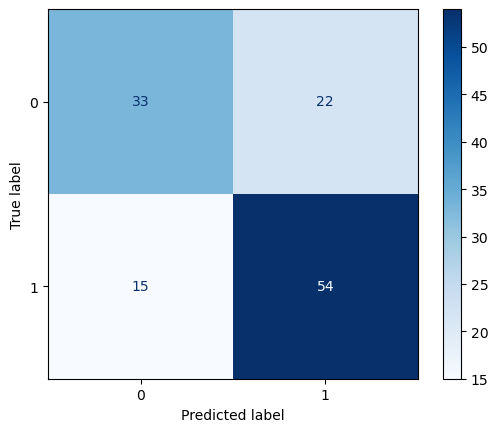

In [180]:
cm = confusion_matrix(y_true=y_test, y_pred=preds2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)

disp.plot(cmap='Blues')

In [181]:
accuracy2 = accuracy_score(y_true=y_test, y_pred=preds2)
print(f"Accuracy: {accuracy2 * 100.0 :.2f}")

Accuracy: 70.16


# Model 3 - Logistic regression

In [182]:
model3 = LogisticRegression(solver='liblinear', random_state=42)
model3.fit(X_train, y_train)
preds3 = model3.predict(X_test)


## Model 3 testing

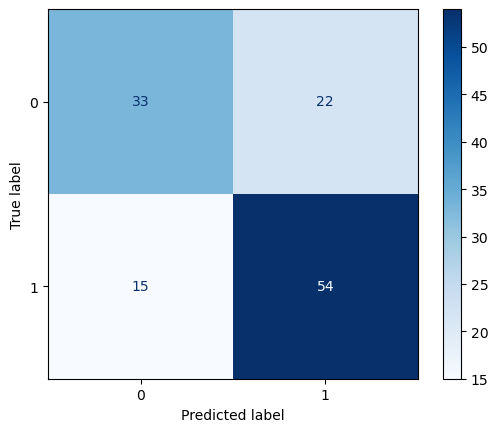

In [183]:
cm = confusion_matrix(y_true=y_test, y_pred=preds3)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)

disp.plot(cmap='Blues')

In [184]:
print(model3.score(X_test, y_test))
accuracy3 = accuracy_score(y_true=y_test, y_pred=preds3)
print(f"Accuracy: {accuracy3 * 100.0 :.2f}")

0.6854838709677419
Accuracy: 68.55


In [185]:
print(classification_report(y_test, preds3))

              precision    recall  f1-score   support

           0       0.67      0.56      0.61        55
           1       0.69      0.78      0.73        69

    accuracy                           0.69       124
   macro avg       0.68      0.67      0.67       124
weighted avg       0.68      0.69      0.68       124



# Model 4 - Logistic regression with optuna

In [186]:
heyho = {'hello': 'hi'}

if 'hello' in heyho:
    index = list(heyho.values())[0]

print(index)

hi


In [187]:
def check_value_exist(dict: dict, liste: list) -> bool:
    do_exist = False
    for l in liste:
            for key, val in dict.items():
                if val == l:
                    do_exist = True
    return do_exist

In [188]:
def objective(trial):
    """
    Tests parameters for sciKit LogicalRegression
    """


    # Cant use suggest_categorical for multiple strings. Crashes
    # Tried with setting string values from random list number, dont work
    # CANT ACTUALLY SET STRING VALUES WIHTOUT USING CATEGORICAL, and that not workign with multiple
    # Solver
    # solver_num = random.randint(0, 4)
    # solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    solver = 'liblinear' # solver_list[solver_num]
    # fit_intercept
    # fit_num = trial.suggest_int('fit_num', 0, 1)

    params = {
        'tol': trial.suggest_float('tol', 1e-5, 1e-1),
        'C': trial.suggest_float('C', 0.0, 1.0),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'random_state': trial.suggest_int('random_state', 0, 50),
        'intercept_scaling': trial.suggest_float('intercept_scaling', 0, 1.0),
        'solver': trial.suggest_categorical('solver', [solver]),
        'max_iter': trial.suggest_int('max_iter', 0, 60)
    }

    # Pentalty
    #if check_value_exist(params, ['newton-cg', 'lbfgs', 'sag']):
    #    number = random.randint(0, 1)
    #    if number == 1:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #    else:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["none"])})
    #elif check_value_exist(params, ['liblinear']):
    #number = random.randint(0, 1)
    #if number == 1:
    params.update({'penalty': trial.suggest_categorical('penalty', ["l1", "l2"])}) # l1 sucks with liblinear, dont use
    #else:
    #    params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #elif check_value_exist(params, ['saga']):
    #    number = random.randint(0, 3)
    #    if number == 0:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["elasticnet"])})
    #    elif number == 1:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l2"])})
    #    elif number == 2:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["l1"])})  
    #    else:
    #        params.update({'penalty': trial.suggest_categorical('penalty', ["none"])}) 

    # l1_ratio //sucks balls man
    if check_value_exist(params, ['l1', 'elasticnet']):
        params.update({'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0)})

    # Dual
    if check_value_exist(params, ['l2']) and check_value_exist(params, ['liblinear']):
        params.update({'dual': trial.suggest_categorical('dual', [True, False])})
    #else:
    #    params.update({'dual': trial.suggest_categorical('dual', [False])})

    # Fit the model
    optuna_model = LogisticRegression(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = opt.create_study(direction="maximize")
study.optimize(objective, n_trials=FOUR_TRIALS)

[I 2023-03-11 18:44:30,310] A new study created in memory with name: no-name-5056b7ba-e17e-451c-a2c2-b86e892f7c01
c:\Users\sigzu\miniconda3\envs\billettkontroll3.10\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-03-11 18:44:30,318] Trial 0 finished with value: 0.6370967741935484 and parameters: {'tol': 0.0936544871706251, 'C': 0.6340782967194609, 'fit_intercept': False, 'random_state': 17, 'intercept_scaling': 0.3055687361853543, 'solver': 'liblinear', 'max_iter': 52, 'penalty': 'l2', 'dual': True}. Best is trial 0 with value: 0.6370967741935484.
c:\Users\sigzu\miniconda3\envs\billettkontroll3.10\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-03-11 18:44:30,323] Trial 1 finished with value: 0.7016129032258065 and parameters: {'tol': 0.0737365973159774, 'C': 0.66278045977522

In [189]:
bparams = study.best_params
model4 = LogisticRegression(**bparams)
model4.fit(X_train, y_train)
preds4 = model4.predict(X_test)
bparams

c:\Users\sigzu\miniconda3\envs\billettkontroll3.10\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\sigzu\miniconda3\envs\billettkontroll3.10\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'tol': 0.09306122649118874,
 'C': 0.24926710840640826,
 'fit_intercept': True,
 'random_state': 31,
 'intercept_scaling': 0.02232197979163957,
 'solver': 'liblinear',
 'max_iter': 2,
 'penalty': 'l1',
 'l1_ratio': 0.8647664646886355}

## Model 4 testing

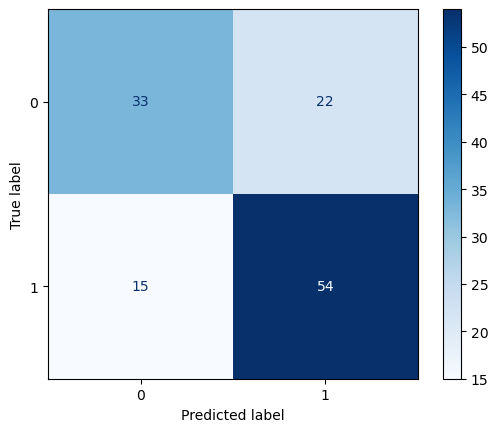

In [190]:
cm = confusion_matrix(y_true=y_test, y_pred=preds4)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)

disp.plot(cmap='Blues')

In [191]:
print(model4.score(X_test, y_test))
accuracy4 = accuracy_score(y_true=y_test, y_pred=preds4)
print(f"Accuracy: {accuracy4 * 100.0 :.2f}")

0.717741935483871
Accuracy: 71.77


# Best

In [192]:
accuracies = [accuracy, accuracy2, accuracy3, accuracy4]

counter = 1
best_a = 0
for a in accuracies:
    if a > best_a:
        best = counter
        best_a = a
    
    counter = counter+1

print(f"Best is model number {best} with the score: {best_a * 100 :.2f}")

Best is model number 4 with the score: 71.77


In [193]:
import json
from datetime import datetime
import pytz
import pickle as pk

In [194]:
utc = pytz.utc


if best == 1:
    bmodel = model
elif best == 2:
    bmodel = model2
elif best == 3:
    bmodel = model3
else:
    bmodel = model4

try:
    bmodel.save_model("../models/model.h5")
except:
    print("Can't save to H5 format.")

pk.dump(bmodel, open('../models/model.pkl', 'wb'))
pk.dump(best_a, open('../accuracy/accuracy.pkl', 'wb'))

with open("../models/dates.json", "r+") as f:
    data = json.load(f)

with open("../models/dates.json", "w") as f:
    date = datetime.now(utc)
    data["newest_model"] = {"day": date.day, "month": date.month, "year": date.year}
    json.dump(data, f)

Can't save to H5 format.


If this runs best model is better than altime best model, replace with this

In [195]:
if SAVE_AS_BEST:
    pk.dump(bmodel, open('../models/best_model.pkl', 'wb'))
    pk.dump(best_a, open('../accuracy/best_accuracy.pkl', 'wb'))

    print(f"This rounds best model with {best_a * 100 :.2f}% was saved as alltime best due to config.")
else:
    best_best_a = pk.load(open('../accuracy/best_accuracy.pkl', 'rb'))

    if best_a > best_best_a:
        pk.dump(bmodel, open('../models/best_model.pkl', 'wb'))
        pk.dump(best_a, open('../accuracy/best_accuracy.pkl', 'wb'))
        best_best_a = best_a

    print(f"Best: {best_a} Best_best: {best_best_a}")

with open("../models/dates.json", "r+") as f:
    data = json.load(f)

with open("../models/dates.json", "w") as f:
    date = datetime.now(utc)
    data["best_model"] = {"day": date.day, "month": date.month, "year": date.year}
    json.dump(data, f)

Best: 0.717741935483871 Best_best: 0.7903225806451613


In [196]:
pk.dump(X_test, open('../categories/X_test.pkl', 'wb'))

In [197]:
if SAVE_AS_BEST or best_a > best_best_a:
    pk.dump(linjeCat, open('../categories/linjeCat.pkl', 'wb'))
    pk.dump(vognCat, open('../categories/vognCat.pkl', 'wb'))
    pk.dump(fraCat, open('../categories/fraCat.pkl', 'wb'))
    pk.dump(tilCat, open('../categories/tilCat.pkl', 'wb'))
    pk.dump(fulltCat, open('../categories/fulltCat.pkl', 'wb'))
    pk.dump(sjekketCat, open('../categories/sjekketCat.pkl', 'wb'))

# Self testing

In [198]:
X_test.head(5)

,Linje,Fra,Til,Fullt?,Dag,Måned,Time,Minutt
78,5,0,7,0,15,2,7,52
92,4,5,8,1,23,4,13,23
454,4,2,7,0,29,4,8,1
65,2,3,0,0,6,10,10,41
101,2,6,0,0,8,3,16,54


In [199]:
y_test.head(5)

78     1
92     0
454    0
65     1
101    1
Name: Sjekket?, dtype: int8

In [200]:
tester = X_test
tester = tester.drop(X_test.index)
tester

# Parameters
linje = "re11"
#vogn = "fremst"
fra = "nationaltheatret"
til = "eidsvoll"
fullt = "ja"
dag = 31
måned = 10
time = 14
minutt = 35

data = {"Linje": [findCatCode(linjeCat, linje)], 
          #"Vogn": [findCatCode(vognCat, vogn)],
          "Fra": [findCatCode(fraCat, fra)], 
          "Til": [findCatCode(tilCat, til)], 
         "Fullt?": [findCatCode(fulltCat, fullt)],
         "Dag": [dag],
         "Måned": [måned],
         "Time": [time],
         "Minutt": [minutt]}

testdb = pd.DataFrame(data)

tester = pd.concat([tester, testdb])
tester


,Linje,Fra,Til,Fullt?,Dag,Måned,Time,Minutt
0,6,4,0,0,31,10,14,35


In [201]:
# Finds what the number means
ja = findCatCode(sjekketCat, 'ja')
nei = findCatCode(sjekketCat, 'nei')

print(f"{nei} = Nei\n"+
      f"{ja} = Ja")

testpred = bmodel.predict(tester)
print(f"Predicted: {testpred}")

if testpred[0] == ja:
    print("Ja, det er en sannsynlighet for å bli kontrollert")
else:
    print("Nei, det er liten sannsynlighet for å bli kontrollert")

1 = Nei
0 = Ja
Predicted: [1]
Nei, det er liten sannsynlighet for å bli kontrollert


In [202]:
linjer = list(linjeCat.categories)
linjer

['l1', 'l2', 'r12', 'r13', 'r14', 're10', 're11']